In [12]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

In [13]:
''' Solve Michaelis-Menten equation 
dp/dt = (V * s) / (K + s)
'''
def michaelis_menten(s, v=20, k=15):
    return v*s/(s+k)

s = np.linspace(0, 400, 100)
dp_dt = michaelis_menten(s)

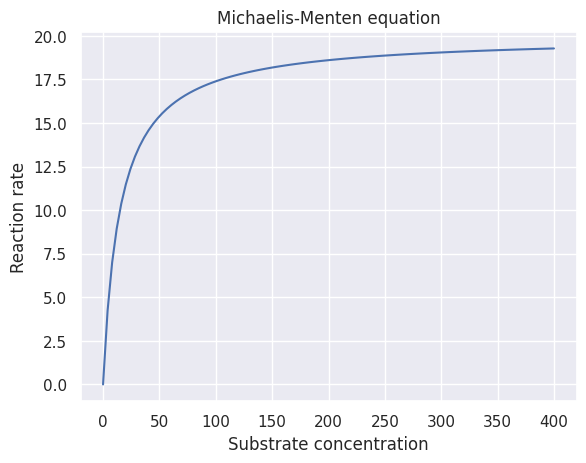

In [17]:
def grad(outputs, inputs):
    """ Computes the partial derivative of 
    an output wrt an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

### Parameter Estimation

In [18]:
def np_to_th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)

class Net(nn.Module):
    def __init__(self, input_dim, output_dim, n_units=100, epochs=100, loss=nn.MSELoss(), \
        lr=1e-3, loss2=None, loss2_weight=0.1) -> None:
        
        super().__init__()
        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)
        
    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out
        
    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)
        
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in range(self.epochs):
            optimizer.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight + self.loss2_weight * self.loss2(self)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if ep % 500 == 0:
                print(f'Epoch {ep}/{self.epochs}, Loss: {loss.item()}')
        return losses
    
    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()
    
class ParameterEstimation(Net):
    def __init__(self, input_dim, output_dim, n_units=100, epochs=100, loss=nn.MSELoss(), lr=0.001,\
        loss2=None, loss2_weight=0.1) -> None:
        super().__init__(input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight)
    
        self.v = nn.Parameter(data=torch.tensor([1.]))  
        self.k = nn.Parameter(data=torch.tensor([1.]))

In [53]:
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 24, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    ys = model(ts)
    dy_dt = grad(ys, ts)[0]
    ode = dy_dt +  * ys
    return torch.mean(ode**2)

In [56]:
param_net = ParameterEstimation(1,1,loss2=physics_loss_discovery, loss2_weight=1, epochs=5000, lr=1e-5).to(DEVICE)

losses = param_net.fit(t_train, y_train)

Epoch 0/5000, Loss: 1.2116167545318604


Epoch 500/5000, Loss: 1.0869638919830322
Epoch 1000/5000, Loss: 1.0165972709655762
Epoch 1500/5000, Loss: 1.00667405128479
Epoch 2000/5000, Loss: 1.0059481859207153
Epoch 2500/5000, Loss: 1.0057315826416016
Epoch 3000/5000, Loss: 1.00554358959198
Epoch 3500/5000, Loss: 1.0053473711013794
Epoch 4000/5000, Loss: 1.0052303075790405
Epoch 4500/5000, Loss: 1.0050865411758423


In [57]:
param_net.k

Parameter containing:
tensor([0.0448], device='cuda:0', requires_grad=True)